In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path

root = Path(".")

%matplotlib inline
sns.set()

plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 140

# Loading data

In [2]:
X_train_full = pd.read_csv('interim_data\\preprocessed_train_features.csv', index_col = 'respondent_id')
y_train_full = pd.read_csv('input_data\\training_set_labels.csv', index_col = 'respondent_id')

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_full = pd.DataFrame(scaler.fit_transform(X_train_full), columns=X_train_full.columns, index=X_train_full.index)

In [4]:
train_df = X_train_full.join(y_train_full)

# Loading test models

In [5]:
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

In [6]:
LogReg_class_h1n1 = LogisticRegressionCV(max_iter=1000, n_jobs=-1)
LogReg_class_seas = LogisticRegressionCV(max_iter=1000, n_jobs=-1)

In [7]:
Ridge_class_h1n1 = RidgeClassifierCV(alphas=[0.1, 0.25, 0.5, 1, 5, 10], cv=5)
Ridge_class_seas = RidgeClassifierCV(alphas=[0.1, 0.25, 0.5, 1, 5, 10], cv=5)

In [8]:
KNN_class_h1n1 = KNeighborsClassifier(n_neighbors=200, weights='distance', n_jobs=-1)
KNN_class_seas = KNeighborsClassifier(n_neighbors=200, weights='distance', n_jobs=-1)

In [9]:
MLP_class_h1n1 = MLPClassifier(max_iter=1000)
MLP_class_seas = MLPClassifier(max_iter=1000)

In [10]:
GaussNB_class_h1n1 = GaussianNB()
GaussNB_class_seas = GaussianNB()

In [11]:
from xgboost import XGBClassifier

with open(root / "models\\XGB_H1N1_best_params.pkl","rb") as f:
    XGB_params_h1n1 = pickle.load(f)

XGB_class_h1n1 = XGBClassifier(**XGB_params_h1n1, objective='reg:logistic', random_state=42, use_label_encoder=False)

with open(root / "models\\XGB_SEAS_best_params.pkl","rb") as f:
    XGB_params_seas = pickle.load(f)

XGB_class_seas = XGBClassifier(**XGB_params_seas, objective='reg:logistic', random_state=42, use_label_encoder=False)

In [12]:
from lightgbm import LGBMClassifier

with open(root / "models\\LGBM_H1N1_best_params.pkl","rb") as f:
    LGBM_params_h1n1 = pickle.load(f)

LGBM_class_h1n1 = LGBMClassifier(**LGBM_params_h1n1)

with open(root / "models\\LGBM_SEAS_best_params.pkl","rb") as f:
    LGBM_params_seas = pickle.load(f)

LGBM_class_seas = LGBMClassifier(**LGBM_params_seas)

In [13]:
from catboost import CatBoostClassifier

CAT_params_h1n1 = {}

CAT_class_h1n1 = CatBoostClassifier(**CAT_params_h1n1)

CAT_params_seas = {}

CAT_class_seas = CatBoostClassifier(**CAT_params_seas)

In [14]:
from sklearn.ensemble import StackingClassifier

STACK_class_h1n1 = StackingClassifier(estimators=[('Logist', LogReg_class_h1n1),
                                                  ('KNN', KNN_class_h1n1),
                                                  ('MLP', MLP_class_h1n1),
                                                  ('GaussNB', GaussNB_class_h1n1),
                                                  ('XGBoost', XGB_class_h1n1),
                                                  ('LightGBM', LGBM_class_h1n1),
                                                  ('CatBoost', CAT_class_h1n1)],
                                      n_jobs=-1,
                                      verbose=3)

STACK_class_seas = StackingClassifier(estimators=[('Logist', LogReg_class_seas),
                                                  ('KNN', KNN_class_seas),
                                                  ('MLP', MLP_class_seas),
                                                  ('GaussNB', GaussNB_class_seas),
                                                  ('XGBoost', XGB_class_seas),
                                                  ('LightGBM', LGBM_class_seas),
                                                  ('CatBoost', CAT_class_seas)],
                                      n_jobs=-1,
                                      verbose=3)

In [15]:
models_h1n1 = {'Logist': LogReg_class_h1n1,
               'RidgeCV': Ridge_class_h1n1,
               'KNN': KNN_class_h1n1,
               'MLP': MLP_class_h1n1,
               'GaussNB': GaussNB_class_h1n1,
               'XGB': XGB_class_h1n1,
               'LGBM': LGBM_class_h1n1,
               'CAT': CAT_class_h1n1,
               'STACK': STACK_class_h1n1}

In [16]:
models_seas = {'Logist': LogReg_class_seas,
               'RidgeCV': Ridge_class_seas,
               'KNN': KNN_class_seas,
               'MLP': MLP_class_seas,
               'GaussNB': GaussNB_class_seas,
               'XGB': XGB_class_seas,
               'LGBM': LGBM_class_seas,
               'CAT': CAT_class_seas,
               'STACK': STACK_class_seas}

# Cross-validating models

In [17]:
from sklearn.model_selection import KFold

N_folds = 5
kf = KFold(n_splits=N_folds, random_state=42, shuffle=True)

for i, (trn, val) in enumerate(kf.split(train_df)):
    train_df.loc[val, 'kfold'] = i
    
train_df['kfold'] = train_df['kfold'].astype(int)

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve

In [19]:
def cross_validate_model(model_name, model_dict, mean_roc_dict, fit_params = {}):
    model = model_dict[model_name]
    print(model_name)
    mean_roc = 0
    for fold in range(N_folds):
        print(f'Fold: {fold}')
        train_idx = train_df['kfold'] != fold
        valid_idx = train_df['kfold'] == fold
        train = train_df.loc[train_idx, :]
        valid = train_df.loc[valid_idx, :]
        
        x_train, y_train = train[feature_cols].values, train[target_cols].values
        x_valid, y_valid = valid[feature_cols].values, valid[target_cols].values
        
        model.fit(x_train, y_train.reshape(-1,), **fit_params)
        
        try:
            y_pred_valid = model.predict_proba(x_valid)[:, 1]
        except:
            y_pred_valid = model.predict(x_valid)
            
        mean_roc += roc_auc_score(y_valid, y_pred_valid)/5
        
    mean_roc_dict[model_name] = [model, mean_roc]

## H1N1 Label

In [20]:
mean_roc_dict_h1n1 = {}

In [21]:
feature_cols = [col for col in X_train_full.columns.tolist() if col not in ['h1n1_vaccine', 'seasonal_vaccine']]
target_cols = ['h1n1_vaccine']

In [22]:
cross_validate_model('Logist', models_h1n1, mean_roc_dict_h1n1)

Logist
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [23]:
cross_validate_model('RidgeCV', models_h1n1, mean_roc_dict_h1n1)

RidgeCV
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [24]:
cross_validate_model('KNN', models_h1n1, mean_roc_dict_h1n1)

KNN
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [25]:
cross_validate_model('MLP', models_h1n1, mean_roc_dict_h1n1)

MLP
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [26]:
cross_validate_model('GaussNB', models_h1n1, mean_roc_dict_h1n1)

GaussNB
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [27]:
cross_validate_model('XGB', models_h1n1, mean_roc_dict_h1n1)

XGB
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [28]:
cross_validate_model('LGBM', models_h1n1, mean_roc_dict_h1n1)

LGBM
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [29]:
cross_validate_model('CAT', models_h1n1, mean_roc_dict_h1n1, fit_params = {'silent': True})

CAT
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [30]:
cross_validate_model('STACK', models_h1n1, mean_roc_dict_h1n1)

STACK
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [31]:
mean_roc_df_h1n1 = pd.DataFrame(mean_roc_dict_h1n1, index = ['Model', 'Mean ROC AUC Score']).transpose().sort_values(by='Mean ROC AUC Score', ascending=False)
mean_roc_df_h1n1

,Model,Mean ROC AUC Score
STACK,"StackingClassifier(estimators=[('Logist',\n ...",0.841426
LGBM,"LGBMClassifier(colsample_bytree=0.9, learning_...",0.84088
XGB,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.840673
CAT,<catboost.core.CatBoostClassifier object at 0x...,0.839624
Logist,"LogisticRegressionCV(max_iter=1000, n_jobs=-1)",0.833049
KNN,"KNeighborsClassifier(n_jobs=-1, n_neighbors=20...",0.794038
GaussNB,GaussianNB(),0.738239
MLP,MLPClassifier(max_iter=1000),0.73384
RidgeCV,"RidgeClassifierCV(alphas=array([ 0.1 , 0.25, ...",0.676262


## SEASONAL Label

In [32]:
mean_roc_dict_seas = {}

In [33]:
feature_cols = [col for col in X_train_full.columns.tolist() if col not in ['h1n1_vaccine', 'seasonal_vaccine']]
target_cols = ['seasonal_vaccine']

In [34]:
cross_validate_model('Logist', models_seas, mean_roc_dict_seas)

Logist
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [35]:
cross_validate_model('RidgeCV', models_seas, mean_roc_dict_seas)

RidgeCV
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [36]:
cross_validate_model('KNN', models_seas, mean_roc_dict_seas)

KNN
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [37]:
cross_validate_model('MLP', models_seas, mean_roc_dict_seas)

MLP
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [38]:
cross_validate_model('GaussNB', models_seas, mean_roc_dict_seas)

GaussNB
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [39]:
cross_validate_model('XGB', models_seas, mean_roc_dict_seas)

XGB
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [40]:
cross_validate_model('LGBM', models_seas, mean_roc_dict_seas)

LGBM
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [41]:
cross_validate_model('CAT', models_seas, mean_roc_dict_seas, fit_params = {'silent': True})

CAT
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [42]:
cross_validate_model('STACK', models_seas, mean_roc_dict_seas)

STACK
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [43]:
mean_roc_df_seas = pd.DataFrame(mean_roc_dict_seas, index = ['Model', 'Mean ROC AUC Score']).transpose().sort_values(by='Mean ROC AUC Score', ascending=False)
mean_roc_df_seas

,Model,Mean ROC AUC Score
STACK,"StackingClassifier(estimators=[('Logist',\n ...",0.86218
CAT,<catboost.core.CatBoostClassifier object at 0x...,0.861232
XGB,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.86048
LGBM,"LGBMClassifier(colsample_bytree=0.6, learning_...",0.860459
Logist,"LogisticRegressionCV(max_iter=1000, n_jobs=-1)",0.852071
KNN,"KNeighborsClassifier(n_jobs=-1, n_neighbors=20...",0.804017
RidgeCV,"RidgeClassifierCV(alphas=array([ 0.1 , 0.25, ...",0.775615
MLP,MLPClassifier(max_iter=1000),0.762391
GaussNB,GaussianNB(),0.748187


# Plotting Best Model

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,
                                                      y_train_full,
                                                      train_size=0.8,
                                                      random_state=42,
                                                      shuffle=True)

In [45]:
def plot_roc(y_true, y_score, label_name, title_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr, label = f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}")
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(title_name)
    ax.legend(loc='lower right')

In [46]:
best_model_h1n1 = mean_roc_df_h1n1.iloc[0]['Model']
best_model_h1n1_name = mean_roc_df_h1n1.index[0]

In [47]:
best_model_h1n1.fit(X_train, y_train['h1n1_vaccine'])

StackingClassifier(estimators=[('Logist',
                                LogisticRegressionCV(max_iter=1000, n_jobs=-1)),
                               ('KNN',
                                KNeighborsClassifier(n_jobs=-1, n_neighbors=200,
                                                     weights='distance')),
                               ('MLP', MLPClassifier(max_iter=1000)),
                               ('GaussNB', GaussianNB()),
                               ('XGBoost',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=0.9, gamma=0,...
                                              reg_lambda=1, scale_pos_weight=1,
                                              subsample=0.8,
                                              tree_method='exact',
          

In [48]:
y_pred_h1n1 = best_model_h1n1.predict_proba(X_valid)[:, 1]

In [49]:
best_model_seas = mean_roc_df_seas.iloc[0]['Model']
best_model_seas_name = mean_roc_df_seas.index[0]

In [50]:
best_model_seas.fit(X_train, y_train['seasonal_vaccine'])

StackingClassifier(estimators=[('Logist',
                                LogisticRegressionCV(max_iter=1000, n_jobs=-1)),
                               ('KNN',
                                KNeighborsClassifier(n_jobs=-1, n_neighbors=200,
                                                     weights='distance')),
                               ('MLP', MLPClassifier(max_iter=1000)),
                               ('GaussNB', GaussianNB()),
                               ('XGBoost',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=0.9, gamma=0,...
                                              subsample=0.7000000000000001,
                                              tree_method='exact',
                                              use_label_encoder=False,
    

In [51]:
y_pred_seas = best_model_seas.predict_proba(X_valid)[:, 1]

In [52]:
y_pred = pd.DataFrame({'h1n1_vaccine': y_pred_h1n1,
                       'seasonal_vaccine': y_pred_seas})

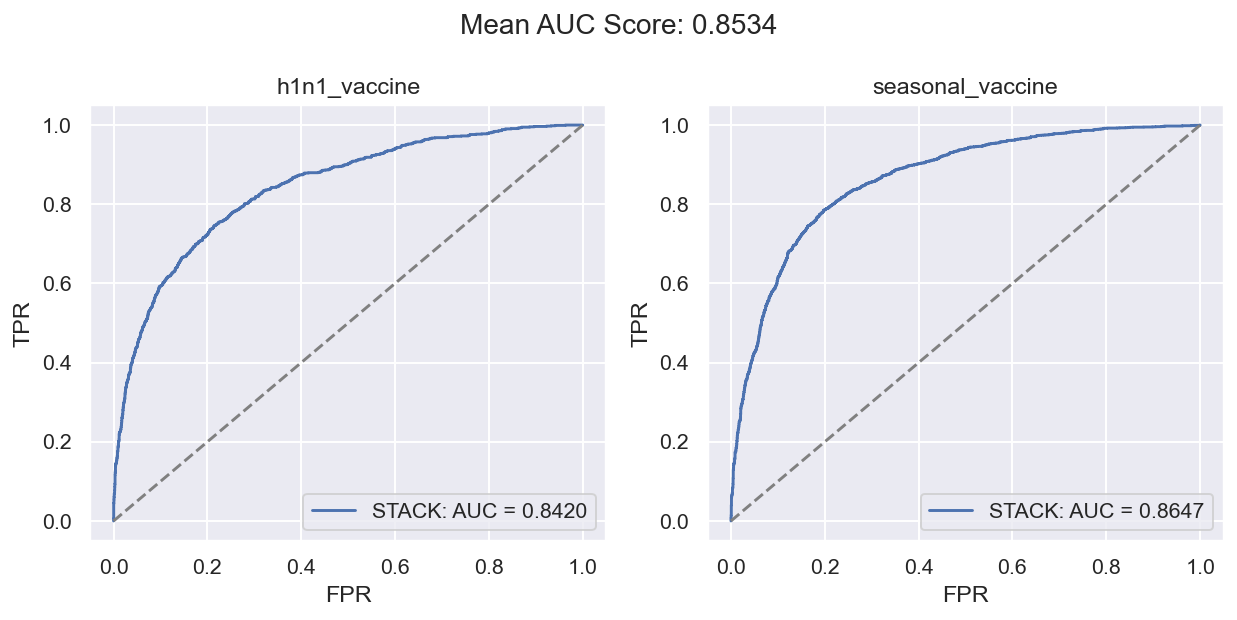

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4.5))

plot_roc(
    y_valid['h1n1_vaccine'], 
    y_pred['h1n1_vaccine'], 
    label_name = best_model_h1n1_name,
    title_name = 'h1n1_vaccine',
    ax=ax[0]
)

plot_roc(
    y_valid['seasonal_vaccine'], 
    y_pred['seasonal_vaccine'], 
    label_name = best_model_seas_name,
    title_name = 'seasonal_vaccine',
    ax=ax[1]
)

mean_auc = (roc_auc_score(y_valid['h1n1_vaccine'], y_pred['h1n1_vaccine']) + roc_auc_score(y_valid['seasonal_vaccine'], y_pred['seasonal_vaccine']))/2
plt.suptitle(f'Mean AUC Score: {mean_auc:.4f}')

fig.tight_layout()

In [54]:
pickle.dump(best_model_h1n1, open('models\\estimator_h1n1.pkl', 'wb'))
pickle.dump(best_model_seas, open('models\\estimator_seas.pkl', 'wb'))